In [2]:
import pandas as pd
import numpy as np
import os
import datetime 
import matplotlib.pyplot as plt
from datetime import date, timedelta
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import scipy.stats
from scipy import stats

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np


import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras import backend as K



In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e8
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 136.2 gigabytes of available RAM

You are using a high-RAM runtime!


In [80]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
data=pd.read_csv("Data.csv")
data.InvoiceDate = pd.to_datetime(data.InvoiceDate,format="%d-%m-%Y")

No null values observed

In [5]:
data.InvoiceDate.min(),data.InvoiceDate.max()


(Timestamp('2018-06-02 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [6]:
data

,InvoiceDate,InvoiceId,SalesUNit,Qty,NetWeight,CustomerName,LineAmount1,Freight,City,State,ItemName,ProductCategory
0,2018-06-02,DD-1819/173,BKT,2.0,40.00,Customer 1,14768.40,0.00,JAMNAGAR,GJ,Item 1,Category 1
1,2018-06-02,DD-1819/167,BKT,150.0,3000.00,Customer 2,660000.00,0.00,HALDIA,WB,Item 1,Category 1
2,2018-06-02,SGE-1819/2172,SET,2.0,48.00,Customer 3,51041.28,106.41,RUDRAPUR,UT,Item 2,Category 2
3,2018-06-04,SGE-1819/2214,SET,7.0,168.00,Customer 4,191618.33,426.74,JAIPUR,RJ,Item 3,Category 2
4,2018-06-04,SGE-1819/2238,BKT,1.0,20.00,Customer 5,11905.42,35.38,GURGAON,HR,Item 1,Category 1
...,...,...,...,...,...,...,...,...,...,...,...,...
1662,2019-12-31,SGE-1920/008073,SET,15.0,360.00,Customer 181,402336.00,1320.03,JAMSHEDPUR,JH,Item 2,Category 2
1663,2019-12-31,SGE-1920/007972,SET,20.0,480.00,Customer 181,536448.00,1158.44,JAMSHEDPUR,JH,Item 2,Category 2
1664,2019-12-31,SGE-1920/008134,CAN,24.0,9.96,Customer 201,5832.00,10.88,KOLHAPUR,MH,Item 5,Category 3
1665,2019-12-31,SGE-1920/008086,CAN,12.0,4.98,Customer 215,3135.05,6.31,JHANSI,UP,Item 5,Category 3


In [7]:
data.isnull().sum()

InvoiceDate        0
InvoiceId          0
SalesUNit          0
Qty                0
NetWeight          0
CustomerName       0
LineAmount1        0
Freight            0
City               0
State              0
ItemName           0
ProductCategory    0
dtype: int64

In [8]:
data.dtypes

InvoiceDate        datetime64[ns]
InvoiceId                  object
SalesUNit                  object
Qty                       float64
NetWeight                 float64
CustomerName               object
LineAmount1               float64
Freight                   float64
City                       object
State                      object
ItemName                   object
ProductCategory            object
dtype: object

In [9]:
print(len(data.InvoiceDate.unique()) , "days of data is observed")

374 days of data is observed


Not so much of data to get seasonality

In [10]:
data.ItemName.unique()

array(['Item 1', 'Item 2', 'Item 3', 'Item 4', 'Item 5'], dtype=object)

In [11]:
data.groupby('ItemName')['InvoiceDate'].nunique()

ItemName
Item 1    249
Item 2    144
Item 3     66
Item 4    104
Item 5    254
Name: InvoiceDate, dtype: int64

Only Item 1 & Item 5 have good no of days of information

In [12]:
data.groupby(['ItemName','SalesUNit'])['InvoiceDate'].nunique()

ItemName  SalesUNit
Item 1    BKT          249
Item 2    SET          144
Item 3    SET           66
Item 4    KIT          100
          SQM            7
Item 5    CAN          254
Name: InvoiceDate, dtype: int64

In [13]:
Weight=data.drop_duplicates(['ItemName','Qty','NetWeight'])
Weight['Unit_weight']=round(Weight.NetWeight/Weight.Qty)
Weight.drop_duplicates(['ItemName','Unit_weight'])[['ItemName','Unit_weight']]

<ipython-input-13-490e0713632b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Weight['Unit_weight']=round(Weight.NetWeight/Weight.Qty)


,ItemName,Unit_weight
0,Item 1,20.0
2,Item 2,24.0
3,Item 3,24.0
5,Item 4,18.0
10,Item 5,0.0
299,Item 4,14.0


In [14]:
data.drop_duplicates(['ItemName','ProductCategory'])[['ItemName','ProductCategory']]

,ItemName,ProductCategory
0,Item 1,Category 1
2,Item 2,Category 2
3,Item 3,Category 2
5,Item 4,Category 2
10,Item 5,Category 3
299,Item 4,Category 1


Item 4 belongs two catagories and it has different weights. It means that we have to treat Item4 cat1 as 1 item and Item 4 cat2 as another item.

In [15]:
data['New_item_name'] = np.where ((data.ItemName=='Item 4')& (data.ProductCategory == 'Category 2') , "Item42",data.ItemName)

In [16]:
data.groupby('New_item_name')['InvoiceDate'].nunique()

New_item_name
Item 1    249
Item 2    144
Item 3     66
Item 4      7
Item 5    254
Item42    100
Name: InvoiceDate, dtype: int64

In [17]:
cities=data.drop_duplicates(['New_item_name','City'])[['New_item_name','City']]
print("Item","  City Name")
for i in cities.New_item_name.unique():
    
    print(i, "\t", cities.loc[cities.New_item_name==i,'City'].nunique())



Item   City Name
Item 1 	 90
Item 2 	 50
Item 3 	 23
Item42 	 39
Item 5 	 94
Item 4 	 6


In [18]:
date_info=data.groupby("New_item_name").agg({'InvoiceDate':['min','max', 'nunique']}).droplevel(0,axis=1).reset_index()
date_info['max'] =pd.to_datetime(date_info['max'])
date_info['min'] =pd.to_datetime(date_info['min'])
date_info['expected_days']=(date_info['max'] - date_info['min']).astype('timedelta64[h]')/24
date_info.columns = ['New_item_name', 'min_date', 'max_date', 'actual_days', 'expected_days']
date_info['available_days_per']=date_info.actual_days / date_info.expected_days
date_info

,New_item_name,min_date,max_date,actual_days,expected_days,available_days_per
0,Item 1,2018-06-02,2019-12-31,249,577.0,0.431542
1,Item 2,2018-06-02,2019-12-31,144,577.0,0.249567
2,Item 3,2018-06-04,2019-12-31,66,575.0,0.114783
3,Item 4,2018-09-18,2019-11-30,7,438.0,0.015982
4,Item 5,2018-06-08,2019-12-31,254,571.0,0.444834
5,Item42,2018-06-05,2019-12-31,100,574.0,0.174216


As we have adequate data for Item5 & Item1  we can go ahead on one of them to  analyse it and replicate the pre-processing for the other items. But this info might not be sufficient to select the right product to do. Let's check for each item wise no fo days of data available with us

In [19]:
def plot_monthwise_no_of_days(item_name):
  
  Item5 = data.loc[data.New_item_name ==item_name,:]
  Item5['yymon']= Item5.InvoiceDate.astype(str).str[2:4] + '-'+ Item5.InvoiceDate.astype(str).str[5:7] 


  Item5=Item5.groupby(['yymon'])['InvoiceDate'].nunique().reset_index().sort_values(by=['yymon']).reset_index()
  f = plt.figure()
  f.set_figwidth(14)
  f.set_figheight(5)
  plt.bar(Item5.yymon, Item5.InvoiceDate, color ='maroon',
        width = 0.4)
 
  plt.xlabel("Months")
  plt.ylabel("No. of days")
  plt.title("Availiable days in a month for :"+ item_name)
  plt.show()

def plot_trend(item_name):
  Item=data.loc[data.New_item_name==item_name,:]
  Item=Item.groupby(['InvoiceDate'])['Qty'].sum().reset_index()
  Item['yymon']= Item.InvoiceDate.astype(str).str[2:4] + '-'+ Item.InvoiceDate.astype(str).str[5:7] 
  f = plt.figure()
  f.set_figwidth(14)
  f.set_figheight(5)
  plt.plot(Item.InvoiceDate, Item.Qty, color='green',  linestyle='dashed',
      linewidth=2, markersize=12) 
  plt.xlabel("Months")
  plt.ylabel("Qty")
  plt.title("Qty trend across months :"+ item_name)
  plt.show()

def plot_days_gap(item_name):
  Item=data.loc[data.New_item_name==item_name,:]
  Item=pd.DataFrame(Item.InvoiceDate.unique())
  Item.columns = ['InvoiceDate']
  Item['day_gap']=Item.InvoiceDate-Item.InvoiceDate.shift(1)
  Item['day_gap']=pd.to_timedelta(Item['day_gap']).dt.days
  Item['yymon']= Item.InvoiceDate.astype(str).str[2:4] + '-'+ Item.InvoiceDate.astype(str).str[5:7] 
  Item=Item.iloc[1:]
  Item=Item.groupby('yymon')['day_gap'].max().reset_index()

  f = plt.figure()
  f.set_figwidth(14)
  f.set_figheight(5)
  plt.bar(Item.yymon, Item.day_gap, color='blue') 
  plt.xlabel("Months")
  plt.ylabel("day_gap")
  plt.title("Maximum day_gap trend across months :"+ item_name)
  plt.show()  



<ipython-input-19-f78c8f81934c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Item5['yymon']= Item5.InvoiceDate.astype(str).str[2:4] + '-'+ Item5.InvoiceDate.astype(str).str[5:7]


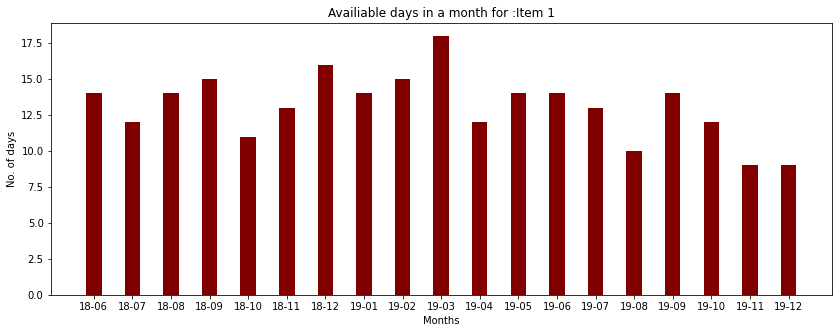

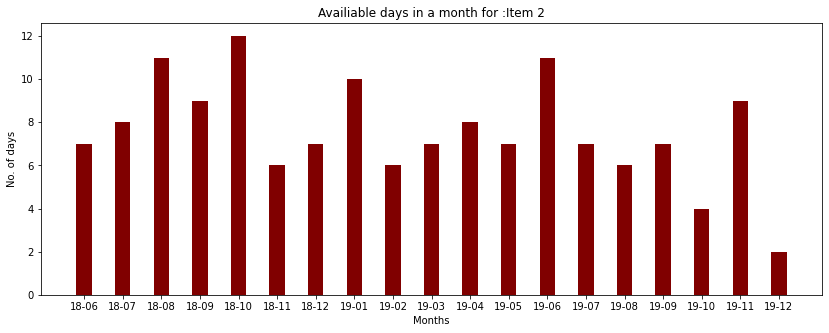

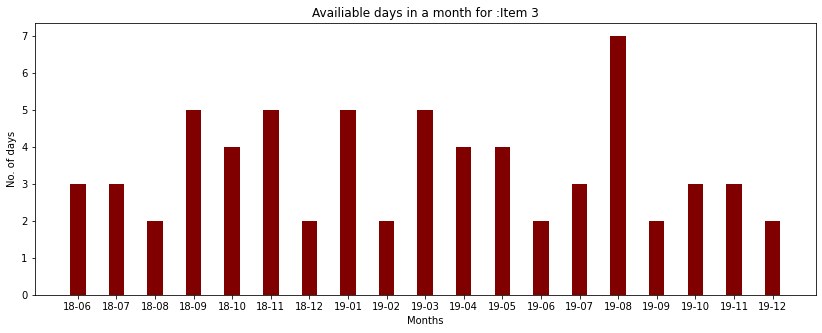

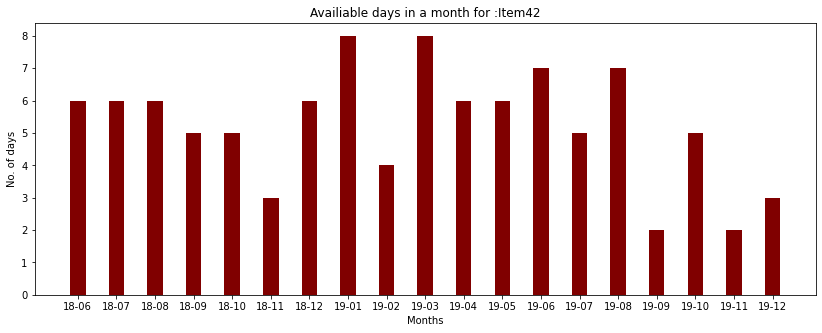

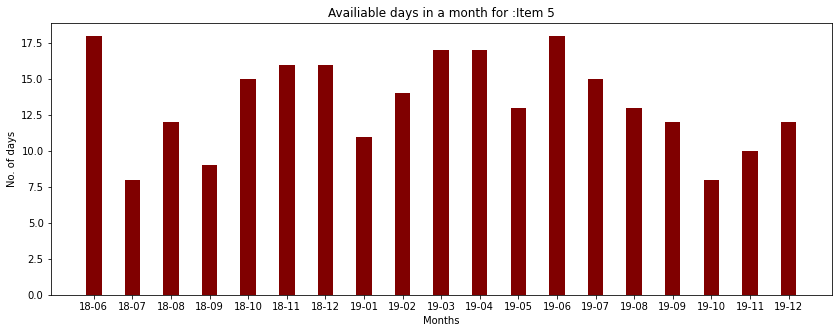

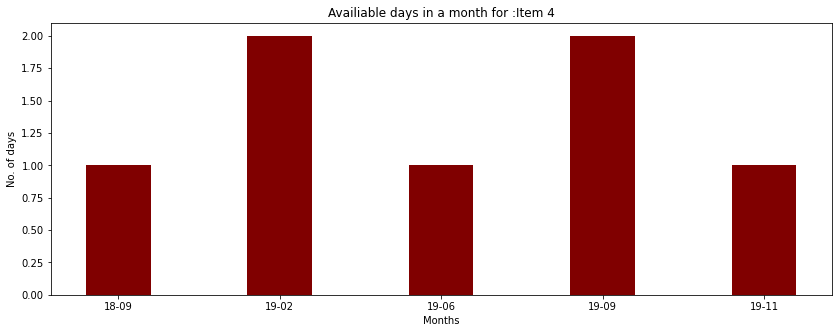

In [20]:
for i in data.New_item_name.unique():
 
  plot_monthwise_no_of_days(i)

We can go with Item1  as we have atleast 10 data point in all the months

No particular purchase pattern in any month. It's mostly random

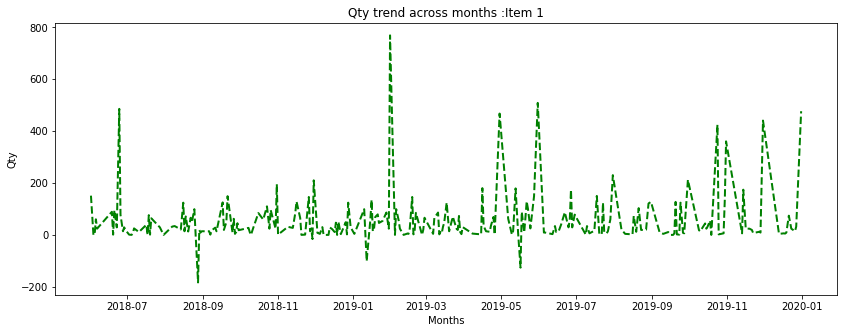

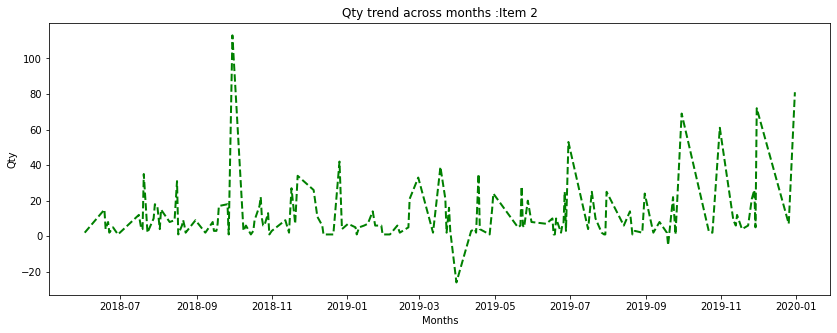

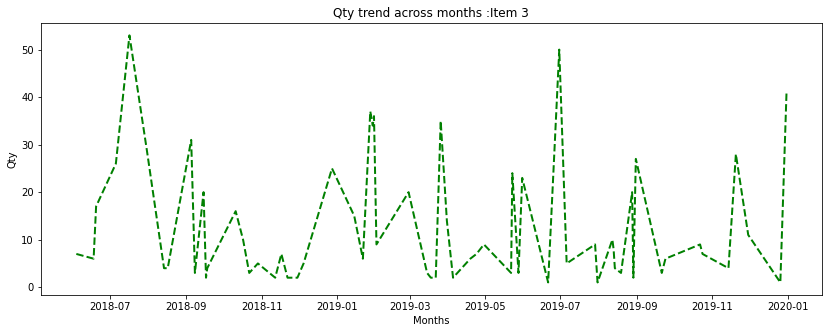

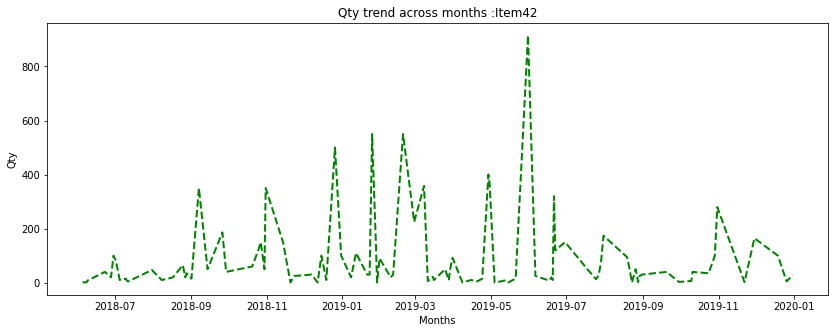

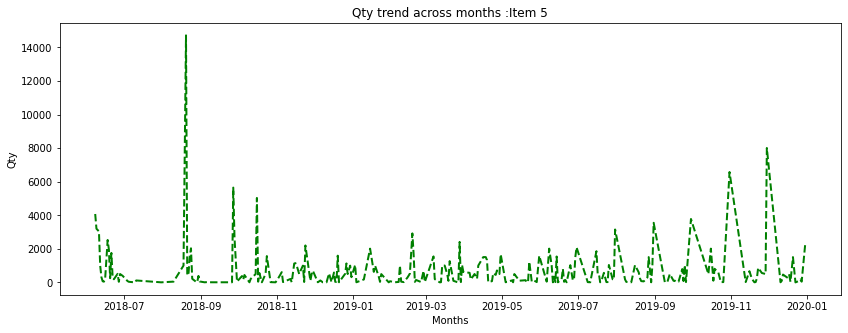

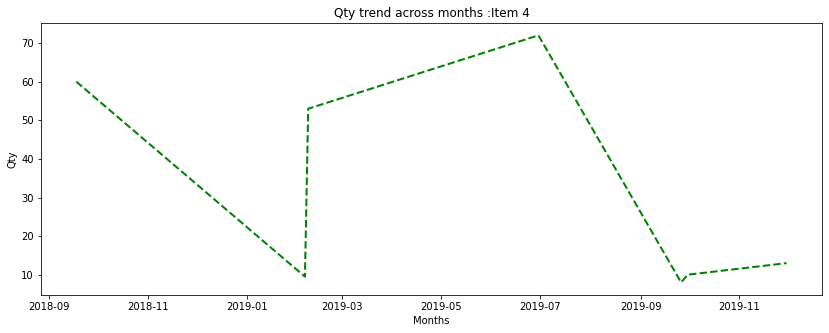

In [21]:
for i in data.New_item_name.unique():
 
  plot_trend(i)

In [22]:
data.loc[data.ItemName=='Item 1',:].head(15)

,InvoiceDate,InvoiceId,SalesUNit,Qty,NetWeight,CustomerName,LineAmount1,Freight,City,State,ItemName,ProductCategory,New_item_name
0,2018-06-02,DD-1819/173,BKT,2.0,40.0,Customer 1,14768.40,0.00,JAMNAGAR,GJ,Item 1,Category 1,Item 1
1,2018-06-02,DD-1819/167,BKT,150.0,3000.0,Customer 2,660000.00,0.00,HALDIA,WB,Item 1,Category 1,Item 1
4,2018-06-04,SGE-1819/2238,BKT,1.0,20.0,Customer 5,11905.42,35.38,GURGAON,HR,Item 1,Category 1,Item 1
6,2018-06-05,SGE-1819/2271,BKT,2.0,40.0,Customer 6,20269.44,0.00,KOLKATA,WB,Item 1,Category 1,Item 1
7,2018-06-06,SGE-1819/2285,BKT,61.0,1220.0,Customer 7,668823.64,2035.58,GOA,GA,Item 1,Category 1,Item 1
8,2018-06-07,SGE-1819/2297,BKT,24.0,480.0,Customer 8,247119.36,0.00,New Delhi,DL,Item 1,Category 1,Item 1
9,2018-06-07,SGE-1819/2300,BKT,1.0,20.0,Customer 9,6804.00,22.00,ANGUL,OR,Item 1,Category 1,Item 1
46,2018-06-19,DD-1819/199,BKT,40.0,800.0,Customer 36,444000.00,0.00,LUCKNOW,UP,Item 1,Category 1,Item 1
48,2018-06-19,SGE-1819/2737,BKT,5.0,100.0,Customer 4,52062.40,169.14,JAIPUR,RJ,Item 1,Category 1,Item 1
54,2018-06-19,SGE-1819/2729,BKT,25.0,500.0,Customer 43,238966.20,899.45,BANGLORE,KA,Item 1,Category 1,Item 1


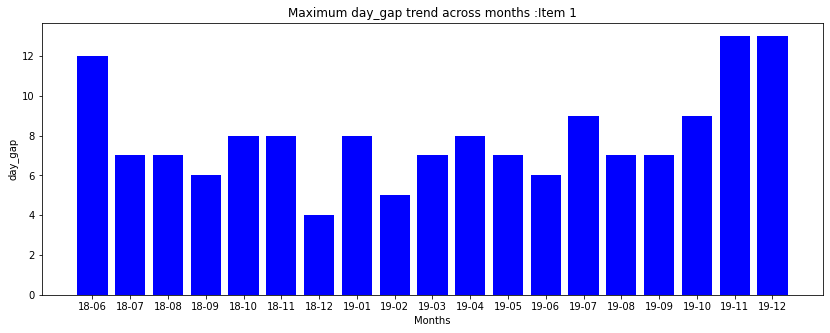

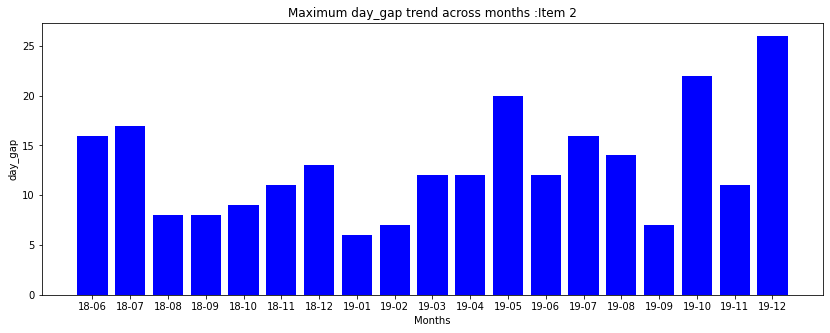

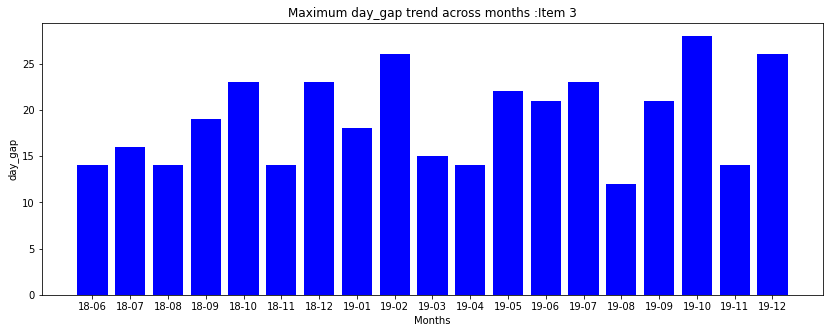

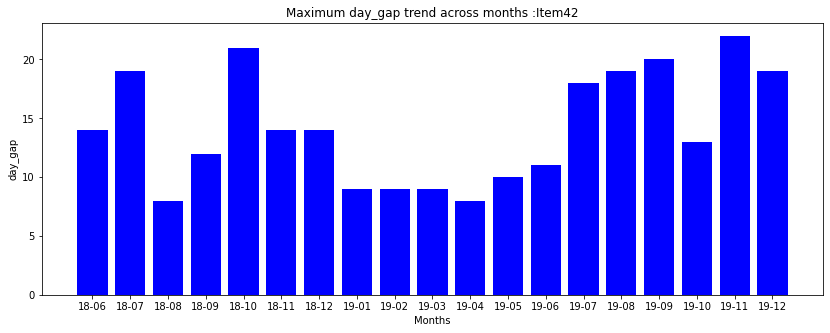

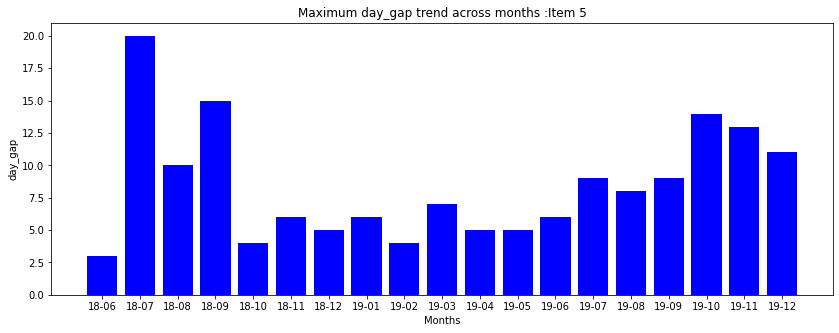

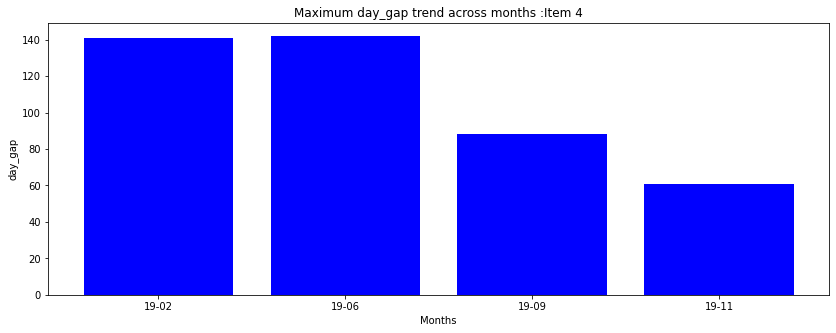

In [23]:
for i in data.New_item_name.unique():
  plot_days_gap(i)

Maximum day gap is around 15 days for every month across all item mostly. We should impute the gaps to forecast a daily or Better to go with a monthly/quarterly horizon while training and forecasting

In [24]:
Item=data.loc[data.New_item_name=='Item 1',:]

In [25]:
Item.loc[Item.CustomerName=='Customer 1',:]

,InvoiceDate,InvoiceId,SalesUNit,Qty,NetWeight,CustomerName,LineAmount1,Freight,City,State,ItemName,ProductCategory,New_item_name
0,2018-06-02,DD-1819/173,BKT,2.0,40.0,Customer 1,14768.4,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1
144,2018-07-19,DD-1819/293,BKT,60.0,1200.0,Customer 1,443052.0,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1
264,2018-08-30,DD-1819/384,BKT,10.0,200.0,Customer 1,73842.0,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1
413,2018-10-20,DD-1819/515,BKT,50.0,1000.0,Customer 1,369210.0,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1
777,2019-02-28,DD-1819/725,BKT,2.0,40.0,Customer 1,14768.4,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1
778,2019-02-28,DD-1819/725,BKT,11.0,220.0,Customer 1,81226.2,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1
779,2019-02-28,DD-1819/725,BKT,15.0,300.0,Customer 1,110763.0,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1
780,2019-02-28,DD-1819/725,BKT,3.0,60.0,Customer 1,22152.6,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1
924,2019-04-23,DD-1920/000019,BKT,1.0,20.0,Customer 1,8040.4,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1
925,2019-04-23,DD-1920/000019,BKT,6.0,120.0,Customer 1,48242.4,0.0,JAMNAGAR,GJ,Item 1,Category 1,Item 1


Customer level data seems pretty random. May be good amount of data or few customers buying products might have an impact

In [26]:
Item.City.value_counts()

AHMEDABAD      35
BHARUCH        27
MUMBAI         25
SONEBHANDRA    22
JAMNAGAR       19
               ..
KYMORE          1
Pendurthy       1
PATALGANGA      1
New Delhi       1
MURSHEDABAD     1
Name: City, Length: 90, dtype: int64

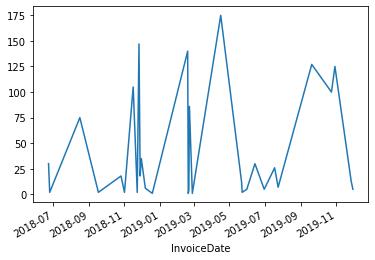

In [27]:
Item.loc[Item.City=='AHMEDABAD',:].groupby('InvoiceDate')['Qty'].sum().plot()

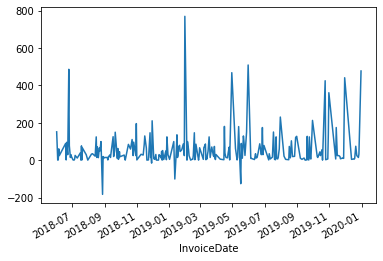

In [28]:
Item.groupby('InvoiceDate')['Qty'].sum().plot()

In [29]:
def data_prep_missing_dates(item_name):
    item=data.loc[data.New_item_name == item_name,:]
    item=item.groupby('InvoiceDate')['Qty'].sum().reset_index()
    possible_dates= set(np.array(pd.DatetimeIndex(pd.date_range(item.InvoiceDate.min(),item.InvoiceDate.max()-timedelta(days=1),freq='d') ,dtype='datetime64[ns]')))
    actual_dates = set(item.InvoiceDate.unique())
    missing_dates = set(possible_dates - actual_dates)
    missing_dates_item=pd.DataFrame({'InvoiceDate':list(missing_dates),'Qty':list(np.zeros(len(missing_dates)))})
    item= pd.concat([item,missing_dates_item],axis=0).sort_values(by='InvoiceDate',ascending=True)
    item.reset_index(drop=True,inplace=True)
    assert item.shape[0]  == (item.InvoiceDate.max() - item.InvoiceDate.min()).days +1 
    return item

# The below features were finlaised after a lot of iterations and we  can even add the day related features etc

In [30]:
def qty_features(item_name):
  item = data_prep_missing_dates(item_name)
  #item['L5_demand']=item.InvoiceDate.apply(lambda x: item.loc[(item.InvoiceDate >= (x - pd.to_timedelta(5, unit='d'))) & (item.InvoiceDate < x ),'Qty'].sum())
  item['L10_demand']=item.InvoiceDate.apply(lambda x: item.loc[(item.InvoiceDate >= (x - pd.to_timedelta(10, unit='d'))) & (item.InvoiceDate < x ),'Qty'].sum())
  item['L15_demand']=item.InvoiceDate.apply(lambda x: item.loc[(item.InvoiceDate >= (x - pd.to_timedelta(15, unit='d'))) & (item.InvoiceDate < x ),'Qty'].sum())
  item['L20_demand']=item.InvoiceDate.apply(lambda x: item.loc[(item.InvoiceDate >= (x - pd.to_timedelta(20, unit='d'))) & (item.InvoiceDate < x ),'Qty'].sum())
  item['L25_demand']=item.InvoiceDate.apply(lambda x: item.loc[(item.InvoiceDate >= (x - pd.to_timedelta(25, unit='d'))) & (item.InvoiceDate < x ),'Qty'].sum())
  item['L30_demand']=item.InvoiceDate.apply(lambda x: item.loc[(item.InvoiceDate >= (x - pd.to_timedelta(30, unit='d'))) & (item.InvoiceDate < x ),'Qty'].sum())

  #item['L510']= (item['L5_demand']-item['L10_demand'])/item['L10_demand']
  item['L1015']= (item['L10_demand']-item['L15_demand'])/item['L15_demand']
  item['L1520']= (item['L15_demand']-item['L20_demand'])/item['L20_demand']
  item['L2025']= (item['L20_demand']-item['L25_demand'])/item['L25_demand']
  item['L2530']= (item['L25_demand']-item['L30_demand'])/item['L30_demand']
  
  #item['L520']= (item['L5_demand']-item['L20_demand'])/item['L20_demand']
  item['L1020']= (item['L10_demand']-item['L20_demand'])/item['L20_demand']
  item['L1025']= (item['L10_demand']-item['L25_demand'])/item['L25_demand']
  item['L1030']= (item['L10_demand']-item['L30_demand'])/item['L30_demand']

  item['L1525']= (item['L15_demand']-item['L25_demand'])/item['L25_demand']
  item['L1530']= (item['L15_demand']-item['L30_demand'])/item['L30_demand']

  




  return item





In [31]:
def target_value(item,step_size=15):
  item['target']=item.InvoiceDate.apply(lambda x: item.loc[(item.InvoiceDate <= (x + pd.to_timedelta(step_size, unit='d'))) & (item.InvoiceDate > x ),'Qty'].sum())
  return item



In [32]:
def train_test_split(item,train_start_month = 2,training_months= 12,testing_months=2):
  max=item.InvoiceDate.max()
  min=item.InvoiceDate.min()
  train_start_date = min + pd.to_timedelta(train_start_month * 30, unit='d')
  train_end_date = train_start_date + pd.to_timedelta(training_months * 30, unit='d')
  test_start_date = train_end_date + pd.to_timedelta(1, unit='d')
  test_end_date =  test_start_date + pd.to_timedelta(testing_months * 30, unit='d')

  X_train = item.loc[(item.InvoiceDate >= (train_start_date)) & (item.InvoiceDate <= (train_end_date)),:].drop(['target','InvoiceDate','Qty'],axis=1)
  Y_train = item.loc[(item.InvoiceDate >= (train_start_date)) & (item.InvoiceDate <= (train_end_date)),'target']
  X_test  = item.loc[(item.InvoiceDate >= (test_start_date)) & (item.InvoiceDate <= (test_end_date)),:].drop(['target','InvoiceDate','Qty'],axis=1)
  Y_test  = item.loc[(item.InvoiceDate >= (test_start_date)) & (item.InvoiceDate <= (test_end_date)),'target']

  print("train start date: ",train_start_date,"train end date",train_end_date )
  print("test start date: ",test_start_date,"test end date",test_end_date )
  
  print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)
  return  X_train, Y_train,X_test,Y_test


def show_plot(model):
  
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  indices=np.random.randint(11,50) 
  history_indices = list(range(indices - 10,indices))
  future_indices =  list(range(indices,indices + 10))


  pred = model.predict(X_test.iloc[future_indices,])
  history = Y_test.iloc[history_indices]
  real = Y_test.iloc[future_indices]


  plt.plot(history_indices, history.values.flatten(), marker[0], label=labels[0])

  plt.plot(future_indices, real.values.flatten(), marker[1], label=labels[1])
  plt.plot(future_indices, pred.flatten(), marker[2], label=labels[2])
  plt.legend()
  plt.xlabel('Time-Step')
  plt.show()

def xg_boost_model():
  model = XGBRegressor()
  model.fit(X_train,Y_train)
  print("\n mape is", mape(model,X_test,Y_test) )
  return model

def create_time_steps(length):
  return list(range(0, length))

print(create_time_steps(20))
def mape(model,X_test,Y_test):
  return np.mean(abs(model.predict(X_test)-Y_test)/Y_test)

      

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


#Model Building to predict the next 15 days of data
- No outlier detection performed yet
- Just based on qty features with different buckets
- Train start date is  from 60 days from  2nd June 2018
- Train end date is from June 2018 + 60 + 270 days
- Test start date from train end date +1 
- Test end date is test start date + 60 days



 Plotting the 15 day demand pattern in the entire data 
 


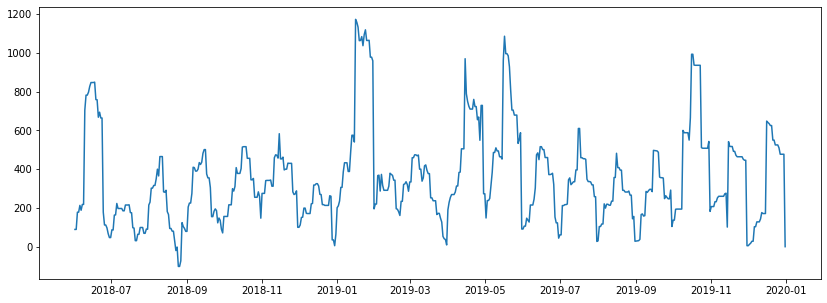

train start date:  2018-08-01 00:00:00 train end date 2019-07-27 00:00:00
test start date:  2019-07-28 00:00:00 test end date 2019-09-26 00:00:00
(361, 14) (361,) (61, 14) (61,)
[16:44:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 mape is 1.0592440048343545

 Plotting for some data points


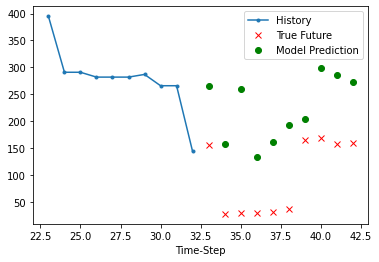

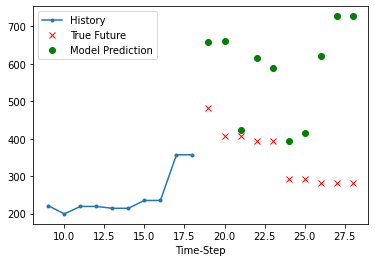

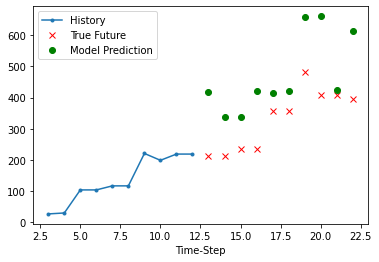

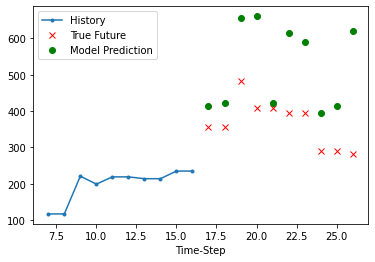

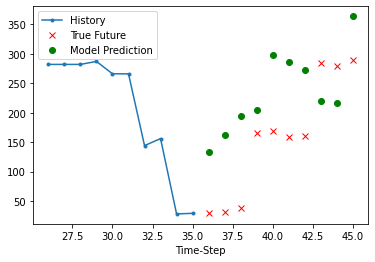

,feature,weight
5,L1015,0.238319
7,L2025,0.113220
12,L1525,0.092785
9,L1020,0.077829
6,L1520,0.069750
8,L2530,0.057148


In [33]:
item = qty_features('Item 1')
item=target_value(item)
print(""" Plotting the 15 day demand pattern in the entire data \n """)
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(5)
plt.plot(item.InvoiceDate,item.target)
plt.show()
X_train, Y_train,X_test,Y_test = train_test_split(item,train_start_month = 2,training_months= 12,testing_months=2)
  
model=xg_boost_model()
print("""\n Plotting for some data points""")
for i in range(5):
    show_plot(model)
pd.DataFrame({'feature': list(X_train.columns), 'weight':list(model.feature_importances_)}).sort_values(by='weight',ascending=False).head(6)    

Got some 105 % mape. Too huge.
It is evident that most important features are the rate of change features. And mostly the L10

Let's try by increasing the train data from 12 months to 14 months

 Plotting the 15 day demand pattern in the entire data 
 


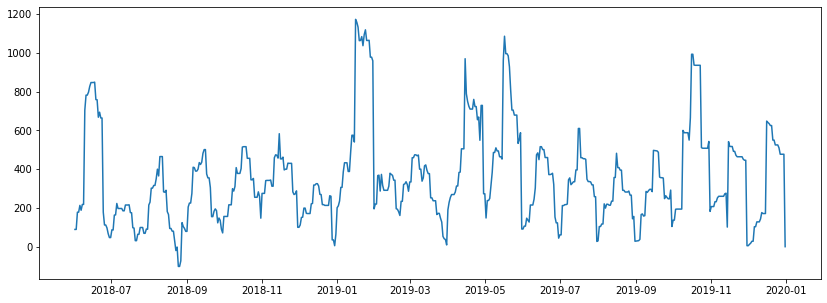

train start date:  2018-08-01 00:00:00 train end date 2019-09-25 00:00:00
test start date:  2019-09-26 00:00:00 test end date 2019-11-25 00:00:00
(421, 14) (421,) (61, 14) (61,)
[16:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 mape is 0.45994042465085777

 Plotting for some data points


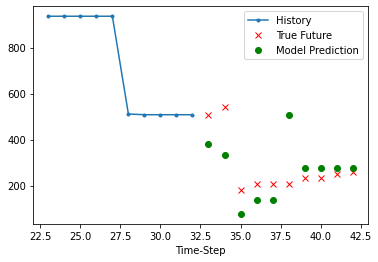

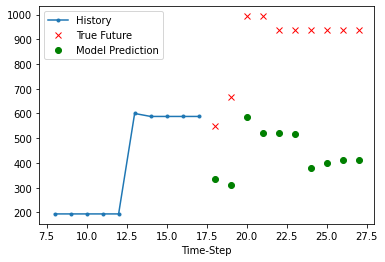

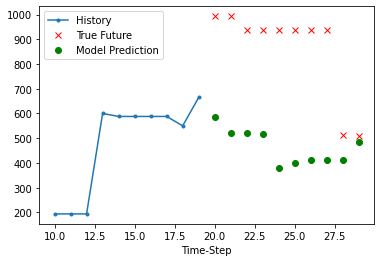

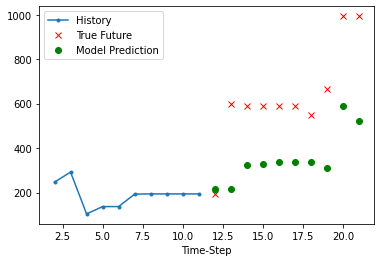

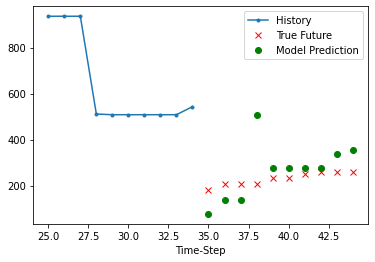

,feature,weight
5,L1015,0.159647
7,L2025,0.113477
8,L2530,0.108147
12,L1525,0.095437
9,L1020,0.081295
6,L1520,0.073218


In [34]:

item = qty_features('Item 1')
item=target_value(item)
print(""" Plotting the 15 day demand pattern in the entire data \n """)
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(5)
plt.plot(item.InvoiceDate,item.target)
plt.show()
X_train, Y_train,X_test,Y_test = train_test_split(item,train_start_month = 2,training_months= 14,testing_months=2)
  
model=xg_boost_model()
print("""\n Plotting for some data points""")
for i in range(5):
    show_plot(model)
pd.DataFrame({'feature': list(X_train.columns), 'weight':list(model.feature_importances_)}).sort_values(by='weight',ascending=False).head(6)    

Great. MAPE reduced to 45 % , because the data for Item 1 has increased during the last phases as shown in fig below.

Also, other good thing is the recency rate change feature'w weight has been reduced and other features are also contributing to the model prediction. 

 The demand across the time line in the data 
 


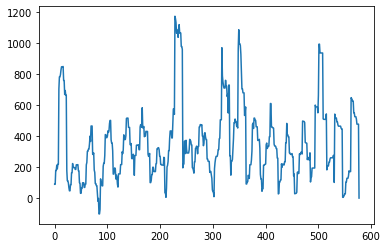

In [35]:
item.target.plot() 
print(""" The demand across the time line in the data \n """)

#Model Building to predict the next 30 days of data
- No outlier detection performed yet
- Just based on qty features with different buckets
- Train start date is  from 60 days from  2nd June 2018
- Train end date is from June 2018 + 60 + 14 months
- Test start date from train end date +1 
- Test end date is test start date + 60 days



 Plotting the 30 day demand pattern in the entire data 
 


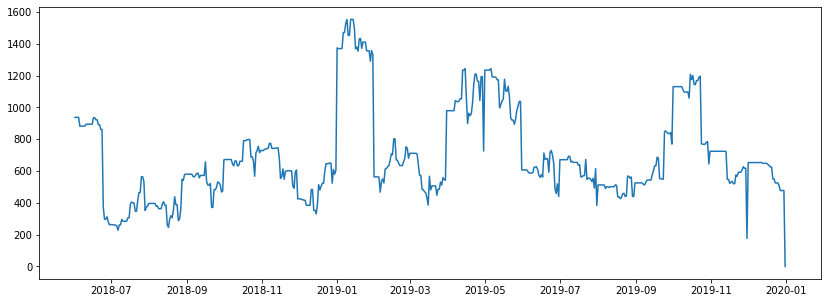

train start date:  2018-08-01 00:00:00 train end date 2019-09-25 00:00:00
test start date:  2019-09-26 00:00:00 test end date 2019-11-25 00:00:00
(421, 14) (421,) (61, 14) (61,)
[16:45:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 mape is 0.3740882590688419

 Plotting for some data points
mae_xgb:  316.4722990442495


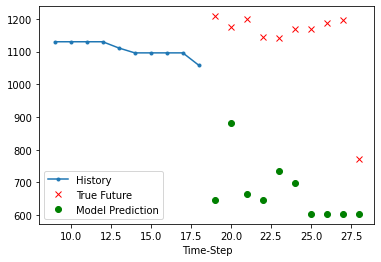

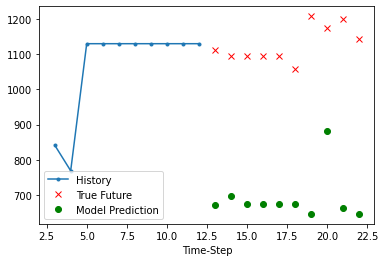

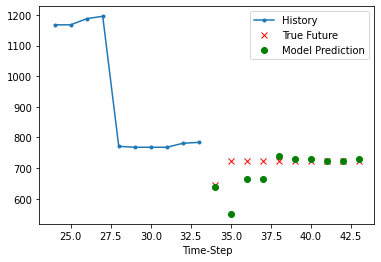

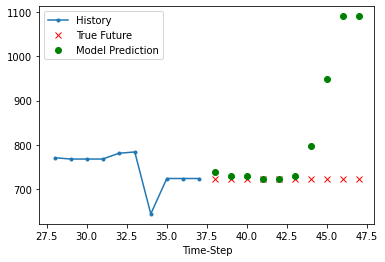

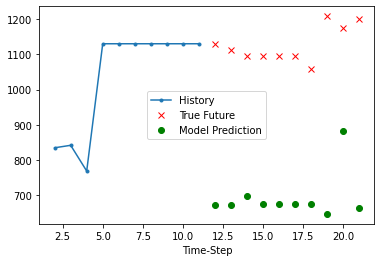

,feature,weight
12,L1525,0.123745
4,L30_demand,0.121862
1,L15_demand,0.104844
3,L25_demand,0.080854
9,L1020,0.079868
0,L10_demand,0.076783


In [36]:

item = qty_features('Item 1')
item=target_value(item,step_size=30)
print(""" Plotting the 30 day demand pattern in the entire data \n """)
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(5)
plt.plot(item.InvoiceDate,item.target)
plt.show()
X_train, Y_train,X_test,Y_test = train_test_split(item,train_start_month = 2,training_months= 14,testing_months=2)
  
model=xg_boost_model()
print("""\n Plotting for some data points""")
y_pred_xgb = model.predict(X_test)
mae_xgb = mean_absolute_error(Y_test, y_pred_xgb)
print('mae_xgb: ', mae_xgb)
for i in range(5):
    show_plot(model)
pd.DataFrame({'feature': list(X_train.columns), 'weight':list(model.feature_importances_)}).sort_values(by='weight',ascending=False).head(6)    

Feature importance for the features has been changed. Last 15 to 25 days rate change play a key role in forecasting future

#Model Building to predict the next 90 days of data
- No outlier detection performed yet
- Just based on qty features with different buckets
- Train start date is  from 60 days from  2nd June 2018
- Train end date is from June 2018 + 60 + 14 months
- Test start date from train end date +1 
- Test end date is test start date + 60 days

 Plotting the 90 day demand pattern in the entire data 
 


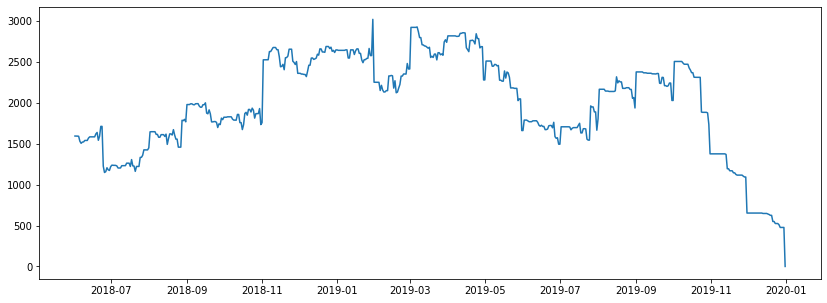

train start date:  2018-08-01 00:00:00 train end date 2019-07-27 00:00:00
test start date:  2019-07-28 00:00:00 test end date 2019-09-26 00:00:00
(361, 14) (361,) (61, 14) (61,)
[16:45:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

 mape is 0.11942308715834643

 Plotting for some data points


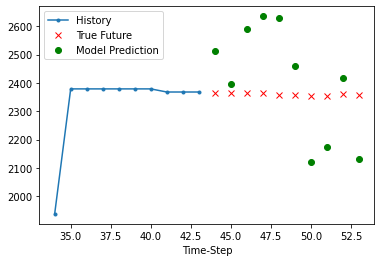

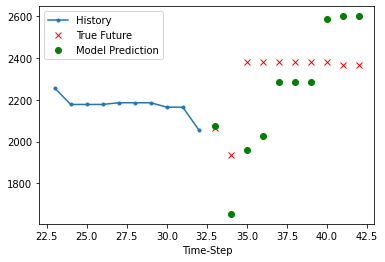

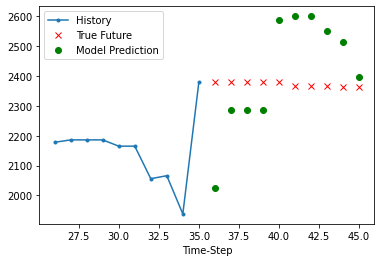

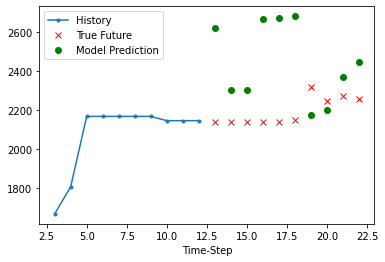

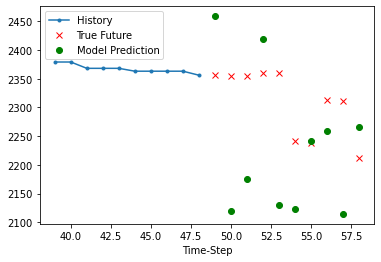

,feature,weight
10,L1025,0.119473
4,L30_demand,0.095900
13,L1530,0.090790
11,L1030,0.086417
8,L2530,0.084183
1,L15_demand,0.072829


In [37]:

item = qty_features('Item 1')
item=target_value(item,step_size=90)
print(""" Plotting the 90 day demand pattern in the entire data \n """)
f = plt.figure()
f.set_figwidth(14)
f.set_figheight(5)
plt.plot(item.InvoiceDate,item.target)
plt.show()
X_train, Y_train,X_test,Y_test = train_test_split(item,train_start_month = 2,training_months= 12,testing_months=2)
  
model=xg_boost_model()
print("""\n Plotting for some data points""")
for i in range(5):
    show_plot(model)
pd.DataFrame({'feature': list(X_train.columns), 'weight':list(model.feature_importances_)}).sort_values(by='weight',ascending=False).head(6)    

#HyperParameter Tuning for 90 days of data with CV as a time series

In [38]:

item = qty_features('Item 1')
item=target_value(item,step_size=90)
X_train, Y_train,X_test,Y_test = train_test_split(item,train_start_month = 3,training_months= 11,testing_months=2)
# the below values are changed based on different iterations to fit the best model
param_tuning = {
        'learning_rate': [0.5,0.6,0.7,0.8],
        'max_depth': [3, 4, 5, 6],
        'min_child_weight': [ 4,5, 6],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.6, 0.7,0.8],
        'n_estimators' : [3,4,6,10,15,20],
        'objective': ['reg:squarederror']
    }

xgb_model = XGBRegressor()

tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = tscv,
                           n_jobs = -1,
                           verbose = 1)

gsearch.fit(X_train,Y_train)

gsearch.best_params_  

# print("""\n Plotting for some data points""")
# for i in range(5):
#     show_plot(model)
# pd.DataFrame({'feature': list(X_train.columns), 'weight':list(model.feature_importances_)}).sort_values(by='weight',ascending=False).head(6)    

train start date:  2018-08-31 00:00:00 train end date 2019-07-27 00:00:00
test start date:  2019-07-28 00:00:00 test end date 2019-09-26 00:00:00
(331, 14) (331,) (61, 14) (61,)
Fitting 2 folds for each of 1728 candidates, totalling 3456 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.5,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 20,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [39]:
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.7,
        learning_rate = 0.5,
        max_depth = 5,
        min_child_weight = 5,
        n_estimators = 20,
        subsample = 0.7)


xgb_model.fit(X_train, Y_train, early_stopping_rounds=5, eval_set=[(X_test, Y_test)], verbose=False)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(Y_test, y_pred_xgb)

print("MAE: ", mae_xgb)
print("MAPE: ",mape(xgb_model,X_test,Y_test))

MAE:  227.8155637647285
MAPE:  0.10386051771099601


The above method is used to only get the 90 days of forecast from current days. But from business point of view, stocking up for 90 days based on one forecast is unreliable.

To convince the stakeholders with numbers, we can split forecast to monthly and compare the actual demand by splitting it into three consecutive forecasts


Eg --  
Actual data will be converted like this
date          next_30 days_demand
01JUNE2022   200 ( sum(demand from 1st June - 3oth June))
01JUNE2022   100 (sum(demand from 1st July - 31st July))
01JUNE2022   150 (sum(demand from 1st Aug - 31st Aug))


lets's say the forecast for 90 days is 500

method 1 :
Now, we should find a method to split 500 into 3 parts.

method 2 :     
try to fit three models by training the above 3 rows seperatly to find forecasts for 0-30 days, 31-60 days and 61-90 days  

Always method2 is efficient, but if the train and test data does not hold any seasonality then we can use the method 1

method 3 :  
try to make the model learn for the next day and run model on top each day to predict the coming daya and so on till 90 days. But this is not fruitful, if we have model makes enromous errors.


In [40]:

def method1_weights_test(xgb_model,X_train_df,Y_train_df):
  y_values=pd.DataFrame({'day_0_y':Y_train_df,'y_pred':xgb_model.predict(X_train_df)})
  y_values['day_30_y']=y_values.day_0_y.shift(-30) 
  y_values['day_60_y']=y_values.day_0_y.shift(-60) 
  y_values.dropna(inplace=True)
  y_values['weight0']=(y_values.day_0_y/y_values.y_pred)
  y_values['weight30']=(y_values.day_30_y/y_values.y_pred)
  y_values['weight60']=(y_values.day_60_y/y_values.y_pred)
  return y_values


def method1_weights_train(Y_train_df):
  y_values = pd.DataFrame({'day_0_y':Y_train_df})
  y_values['day_30_y']=y_values.day_0_y.shift(-30) 
  y_values['day_60_y']=y_values.day_0_y.shift(-60) 
  y_values.dropna(inplace=True) 
  y_values['weight0']=(y_values.day_0_y/(y_values.day_0_y + y_values.day_30_y + y_values.day_60_y))
  y_values['weight30']=(y_values.day_30_y/(y_values.day_0_y + y_values.day_30_y + y_values.day_60_y))
  y_values['weight60']=(y_values.day_60_y/(y_values.day_0_y + y_values.day_30_y + y_values.day_60_y))
  return y_values


Should get 4 months for test to deduce the weights we  go for D+60 days 

In [41]:
item = qty_features('Item 1')
item1=target_value(item,step_size=30)
X_train_df, Y_train_df,X_test_df,Y_test_df = train_test_split(item1,train_start_month = 3,training_months= 11,testing_months=4)

weights_df_train = method1_weights_train(Y_train_df)
weights_df_test = method1_weights_test(xgb_model,X_test_df,Y_test_df)

train start date:  2018-08-31 00:00:00 train end date 2019-07-27 00:00:00
test start date:  2019-07-28 00:00:00 test end date 2019-11-25 00:00:00
(331, 14) (331,) (121, 14) (121,)


In [42]:
def plot_weights(df_train=weights_df_train,df_test = weights_df_test,weight= 'weight0'):
  pdf_train = stats.norm.pdf(df_train[weight].sort_values(), np.mean(df_train.weight0), (df_train.weight0).std())
  pdf_test = stats.norm.pdf(df_test[weight].sort_values(), np.mean(df_test.weight0), (df_test.weight0).std())
  plt.plot(df_train[weight].sort_values(), pdf_train,label= "train weight")
  plt.plot(df_test[weight].sort_values(), pdf_test,label= "test weight")
  plt.legend()
  plt.title(" Distribution of weight: "+weight )



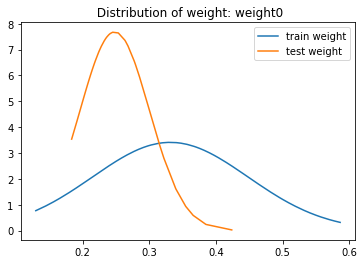

In [43]:
plot_weights()

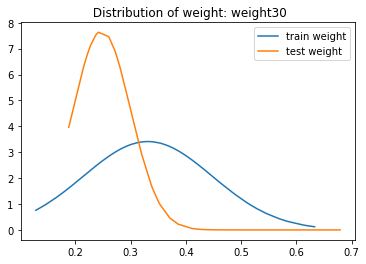

In [44]:
plot_weights(weight = 'weight30')

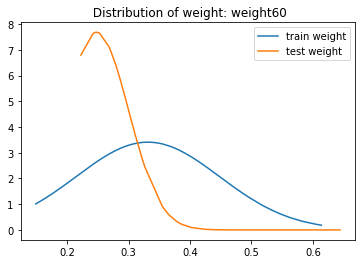

In [45]:
plot_weights(weight = 'weight60')

This is not at all the way I think. Completely bad. 
We can apply any other trasnformation like getting the rate of change of demand as factor and try. One good reason is the rate of change is not stable also gap between the test and train loss

For now shifting to method2.

Hope Method2 might do good.

In [46]:
def target_value_dynamic(item,start_step_size=1, end_step_size=30):
  item['target']=item.InvoiceDate.apply(lambda x: item.loc[(item.InvoiceDate >= (x + pd.to_timedelta(start_step_size, unit='d'))) & (item.InvoiceDate <= (x + pd.to_timedelta(end_step_size, unit='d')) ),'Qty'].sum())
  return item


In [47]:
def dynamic_xgboost_training(start_step_size=1,end_step_size=30) :
  item = qty_features('Item 1')
  item= target_value_dynamic(item,start_step_size=start_step_size, end_step_size=end_step_size)
  print(""" Plotting the date between """ + str(start_step_size) + " & " + str(end_step_size) + """ day demand pattern in the entire data \n """)
  f = plt.figure()
  f.set_figwidth(14)
  f.set_figheight(5)
  plt.plot(item.InvoiceDate,item.target)
  plt.show()
  if end_step_size <= 30:
    X_train, Y_train,X_test,Y_test = train_test_split(item,train_start_month = 2,training_months= 14,testing_months=2)
  elif (end_step_size > 30)  & (end_step_size<=60):
    X_train, Y_train,X_test,Y_test = train_test_split(item,train_start_month = 2,training_months= 13,testing_months=2)
  elif (end_step_size >60):
    X_train, Y_train,X_test,Y_test = train_test_split(item,train_start_month = 2,training_months= 12,testing_months=2)
  param_tuning = {
        'learning_rate': [0.5,0.6,0.7,0.8],
        'max_depth': [3, 4, 5, 6],
        'min_child_weight': [ 4,5, 6],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.6, 0.7,0.8],
        'n_estimators' : [3,4,6,10,15,20],
        'objective': ['reg:squarederror']
    }

  xgb_model = XGBRegressor()

  tscv = TimeSeriesSplit(n_splits=2)
  gsearch = GridSearchCV(estimator = xgb_model,
                            param_grid = param_tuning,                        
                            scoring = 'neg_mean_absolute_error', #MAE
                            #scoring = 'neg_mean_squared_error',  #MSE
                            cv = tscv,
                            n_jobs = -1,
                            verbose = 1)

  gsearch.fit(X_train,Y_train)
  best_params_= gsearch.best_params_  

  xgb_model = XGBRegressor(
        objective = best_params_['objective'],
        colsample_bytree = best_params_['colsample_bytree'],
        learning_rate = best_params_['learning_rate'],
        max_depth = best_params_['max_depth'],
        min_child_weight = best_params_['min_child_weight'],
        n_estimators = best_params_['n_estimators'],
        subsample = best_params_['subsample'])


  xgb_model.fit(X_train, Y_train )

  y_pred_xgb = xgb_model.predict(X_test)

  mae_xgb = mean_absolute_error(Y_test, y_pred_xgb)

  print("MAE: ", mae_xgb)
  print("MAPE: ",mape(xgb_model,X_test,Y_test))
  
  return xgb_model





 Plotting the date between 1 & 30 day demand pattern in the entire data 
 


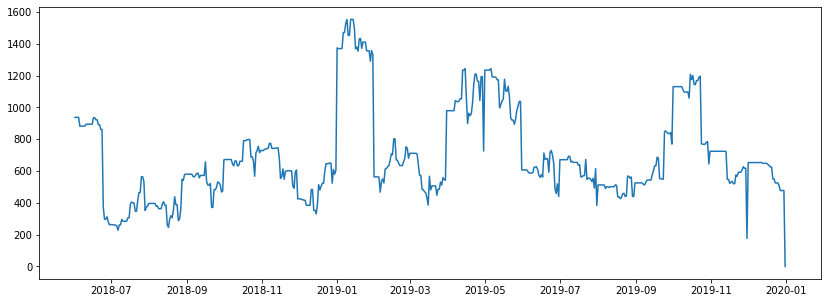

train start date:  2018-08-01 00:00:00 train end date 2019-09-25 00:00:00
test start date:  2019-09-26 00:00:00 test end date 2019-11-25 00:00:00
(421, 14) (421,) (61, 14) (61,)
Fitting 2 folds for each of 1728 candidates, totalling 3456 fits
MAE:  297.3027794009349
MAPE:  0.33241569937293314


In [48]:
model_0=dynamic_xgboost_training(start_step_size=1,end_step_size=30)

 Plotting the date between 31 & 60 day demand pattern in the entire data 
 


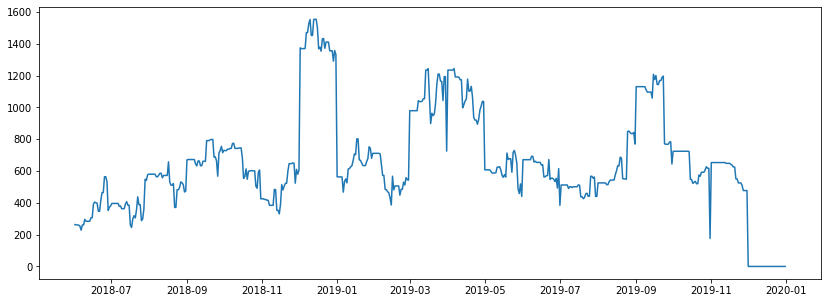

train start date:  2018-08-01 00:00:00 train end date 2019-08-26 00:00:00
test start date:  2019-08-27 00:00:00 test end date 2019-10-26 00:00:00
(391, 14) (391,) (61, 14) (61,)
Fitting 2 folds for each of 1728 candidates, totalling 3456 fits
MAE:  284.85124581759095
MAPE:  0.3320653019002328


In [49]:
model_30=dynamic_xgboost_training(start_step_size=31,end_step_size=60)

 Plotting the date between 61 & 90 day demand pattern in the entire data 
 


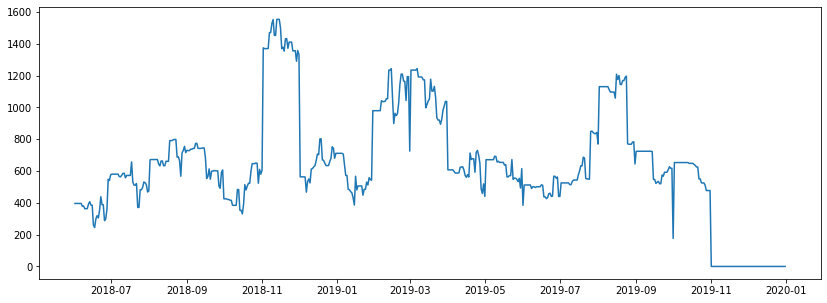

train start date:  2018-08-01 00:00:00 train end date 2019-07-27 00:00:00
test start date:  2019-07-28 00:00:00 test end date 2019-09-26 00:00:00
(361, 14) (361,) (61, 14) (61,)
Fitting 2 folds for each of 1728 candidates, totalling 3456 fits
MAE:  213.454725421843
MAPE:  0.22877429383556147


In [50]:
model_60=dynamic_xgboost_training(start_step_size=61,end_step_size=90)

#LSTM Model

In [53]:
step_size= 30
item = data_prep_missing_dates('Item 1')
item=target_value(item,step_size=step_size)
item['X_var'] = None
item['X_var'][step_size:] = item.InvoiceDate[step_size:].apply(lambda x: np.reshape(item.loc[(item.InvoiceDate > (x - pd.to_timedelta(step_size, unit='d'))) & (item.InvoiceDate <= x ),'Qty'].values,(step_size,1)))
item=item.loc[item.X_var!=None,:]
X_train, Y_train,X_test,Y_test=train_test_split(item,train_start_month = 2,training_months= 14,testing_months=2)


train start date:  2018-08-01 00:00:00 train end date 2019-09-25 00:00:00
test start date:  2019-09-26 00:00:00 test end date 2019-11-25 00:00:00
(421, 1) (421,) (61, 1) (61,)


<ipython-input-53-f7bf6894383c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item['X_var'][step_size:] = item.InvoiceDate[step_size:].apply(lambda x: np.reshape(item.loc[(item.InvoiceDate > (x - pd.to_timedelta(step_size, unit='d'))) & (item.InvoiceDate <= x ),'Qty'].values,(step_size,1)))


In [54]:
X_train = np.array(list(X_train.X_var.values))
Y_train = np.array(list(Y_train))
X_test= np.array(list(X_test.X_var.values))
Y_test= np.array(list(Y_test))

In [57]:
BATCH_SIZE = 6 # bacth size in batch-SGD/variants
BUFFER_SIZE = 100 # for shuffling the dataset
train=tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [58]:
test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test = test.batch(BATCH_SIZE).repeat()

In [59]:
X_train[0]

array([[ 2.],
       [ 0.],
       [ 1.],
       [ 6.],
       [26.],
       [ 0.],
       [ 0.],
       [ 0.],
       [12.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [40.],
       [ 1.],
       [77.],
       [ 2.],
       [65.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [30.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.]])

In [60]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(421, 30, 1)
(421,)
(61, 30, 1)
(61,)


In [61]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae',metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

In [76]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Train and evaluate
STEPS_PER_EPOCH = 400
EPOCHS = 50

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
history=simple_lstm_model.fit(train, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=test, validation_steps=50)

Epoch 1/50
400/400 [==============================] - 5s 12ms/step - loss: 376.9802 - mean_absolute_percentage_error: 46.7413 - val_loss: 545.7033 - val_mean_absolute_percentage_error: 59.2352
Epoch 2/50
400/400 [==============================] - 5s 12ms/step - loss: 367.3828 - mean_absolute_percentage_error: 45.9397 - val_loss: 542.1373 - val_mean_absolute_percentage_error: 58.7973
Epoch 3/50
400/400 [==============================] - 6s 14ms/step - loss: 369.9977 - mean_absolute_percentage_error: 45.7557 - val_loss: 538.5767 - val_mean_absolute_percentage_error: 58.3602
Epoch 4/50
400/400 [==============================] - 5s 12ms/step - loss: 365.7637 - mean_absolute_percentage_error: 45.1007 - val_loss: 535.0101 - val_mean_absolute_percentage_error: 57.9222
Epoch 5/50
400/400 [==============================] - 5s 12ms/step - loss: 354.7964 - mean_absolute_percentage_error: 44.2124 - val_loss: 531.4421 - val_mean_absolute_percentage_error: 57.4842
Epoch 6/50
400/400 [===============

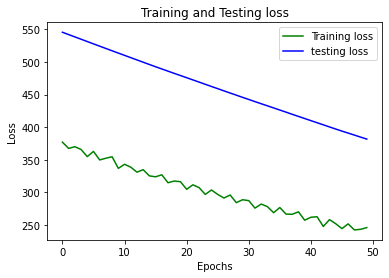

In [86]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,EPOCHS)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

There is a scope to reduce the test loss further as well. This is just a demo to show the deep learning. However, if we have good amount of data, we can do further analysis




In [91]:
mape(simple_lstm_model,X_test,Y_test)

2/2 [==============================] - 0s 7ms/step


0.3763156162119214

Key take aways:

In real time scenarios, we have to make the model work better with lower loss. 

It should be trained to forecast weekly/ daily and take that as an input and predict the next day and so on until for an horizon of 90 days(say)


As we have no confidence on the model, we have to compromise with long range prediction


LSTM models work better in identifying the next token prediction use cases as thier underlying structure is core RNN's 

Things that can be done better:

1. Feature engineering for Xg boost need to be rigorously done to fit to best possible features.  Other features like month information, days gap between last two orders can be included etc.
Some transformormations on the features can be tested.

2. More of outlier detection can be done provided we have good amount of data. We might lose some more info, we have done on the current data.

3. Need to try out product, city level etc if we have good amount of data across cities.

4. More analysis on the each of the hyper parameters and features. Hyper parameter tuning can be done better.

5. We can try out some linear models to check if linearilty and correlation between the target and the demand based features are standing out.


